In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
import requests

In [2]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
import zipfile
from pathlib import Path

In [5]:
NUM_WORKERS = os.cpu_count()

#Creating dataloaders


In [6]:
def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
"""
  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

#Test/Train

In [7]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
"""
  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy).
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
"""
  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy).
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """T
 Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

#Utils

In [8]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """
  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [9]:
def plot_loss_curves(results: Dict[str, List[float]]):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [10]:
def set_seeds(seed: int=42):
    """
    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [11]:
import shutil
def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # Check if necessary files or directories exist in the image_path
    required_files = ["train", "test"]  # Add more if needed
    files_exist = all((image_path / file).exists() for file in required_files)

    if not files_exist:
        print(f"[INFO] Required files not found in {image_path}, downloading and extracting...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(data_path)

        # Move contents to image_path
        for file in required_files:
            shutil.move(data_path / file, image_path / file)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#1. Getting data

In [13]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

PosixPath('data/pizza_steak_sushi')

In [14]:
# Setup directory paths to train and test images
train_dir = image_path/"train"
test_dir = image_path/"test"

#2. Create Datasets and DataLoaders

In [15]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [16]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names =create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7be2dc80d660>,
 ['pizza', 'steak', 'sushi'])

In [17]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

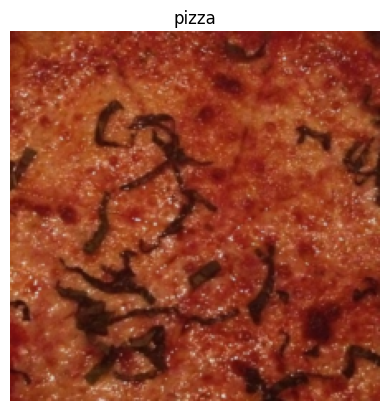

In [18]:
plt.imshow(image.permute(1,2,0)) #Rearranging image dimensions to H*W*C, the format that matplot lib prefs
plt.title(class_names[label])
plt.axis(False)

The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image  
x∈R^H×W×C into a sequence of flattened 2D patches  
xp∈R^N×(P^2⋅C) , where (H,W) is the resolution of the original image, C is the number of channels, (P,P)
is the resolution of each image patch, and  
N=H*W/P^2 is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.


  D is the size of the patch embeddings, different values for
D
 for various sized ViT models can be found in Table 1.
The image starts as 2D with size
H
×
W
×
C
.
(
H
,
W
)
 is the resolution of the original image (height, width).
C
 is the number of channels.
The image gets converted to a sequence of flattened 2D patches with size
N
×
(
P^
2
⋅
C
)
.
(
P
,
P
)
 is the resolution of each image patch (patch size).
N
=
H*
W
/
P^
2
 is the resulting number of patches, which also serves as the input sequence length for the Transformer.

#Calculating patch embedding input and output shapes by hand:

In [19]:
#Creating example values
height = 224 #H
width = 224 #W
colour_channels = 3 #C
patch_size = 16 #P

#Calculate N (numbr of patches)
number_of_patches = int((height*width)/patch_size**2)
print(f'Number of patches (N) with image height (H={height}), width (W={width}), and patch size (P={patch_size}): {number_of_patches}')

Number of patches (N) with image height (H=224), width (W=224), and patch size (P=16): 196


In [20]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, colour_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * colour_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


#Turning an image into patches

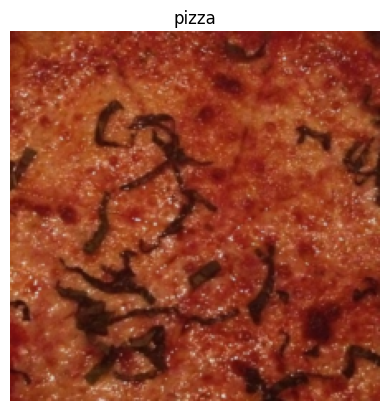

In [21]:
plt.imshow(image.permute(1,2,0)) #adjusted for matplotlib
plt.title(class_names[label])
plt.axis(False);

Visualizing the patches

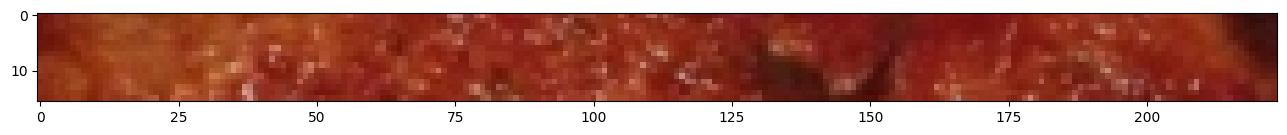

In [22]:
image_permuted = image.permute(1,2,0) #changing the shape to be compatible with matplotlib

#Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


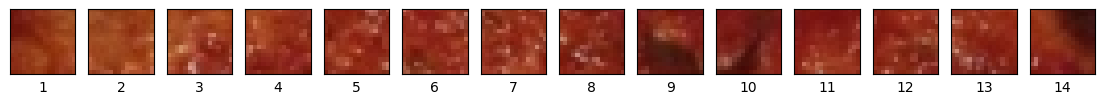

In [23]:
#Setup hyperparameters and make sure img_size and patch size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows = 1,
                       ncols = img_size//patch_size,
                       figsize = (num_patches,num_patches),
                       sharex = True,
                       sharey = True)
# Iterate through the number of patches in the top row
for i, patch in enumerate(range(0,img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) #set the label
  axs[i].set_xticks([])
  axs[i].set_yticks([])


Lets iterate through the whole image

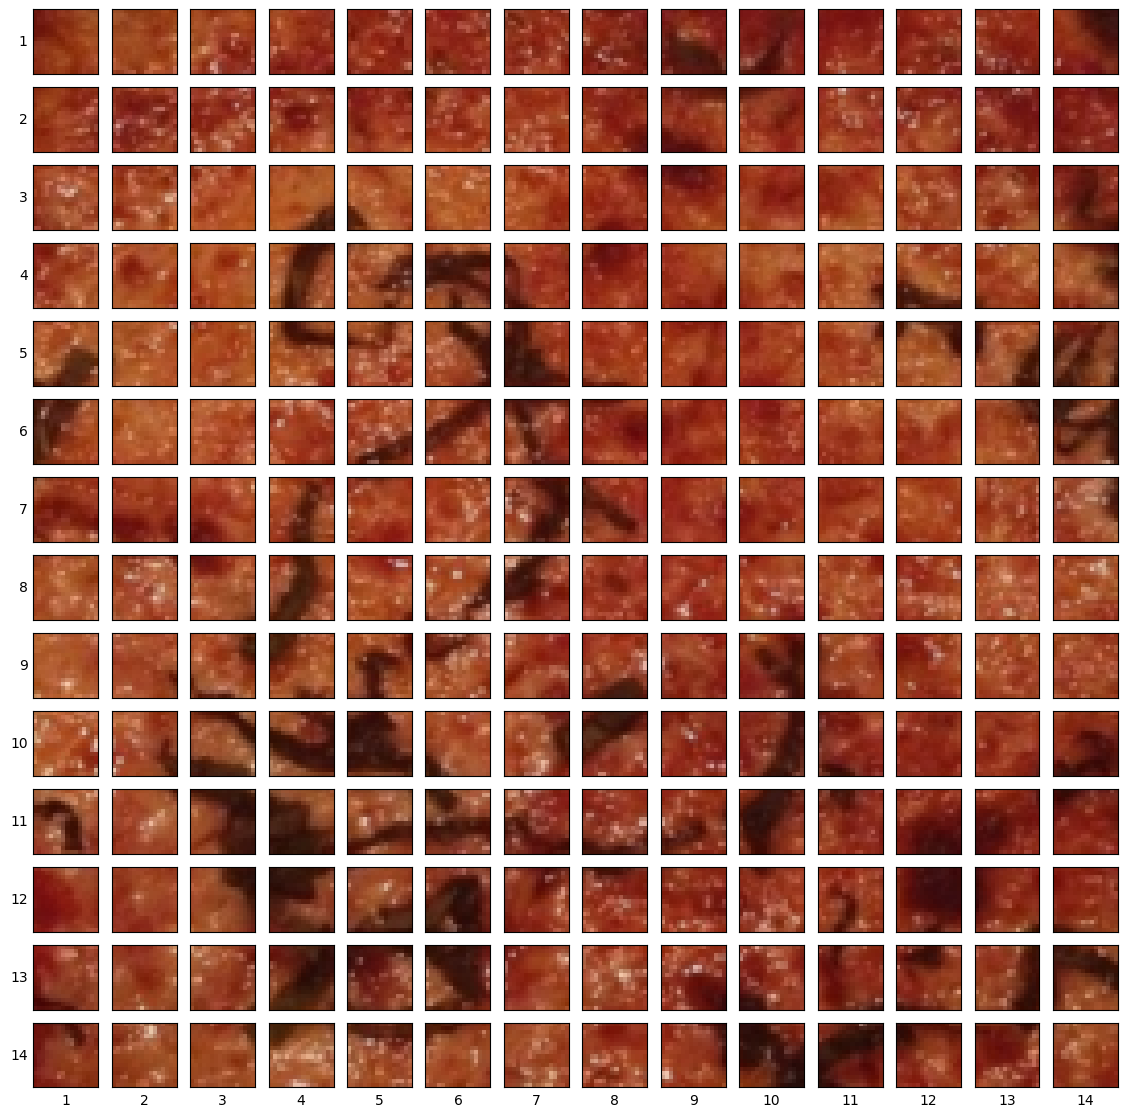

In [24]:
#Setup hyperparameters and make sure img_size and patch size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
# Create a series of subplots
fig, axs = plt.subplots(nrows = img_size//patch_size,
                       ncols = img_size//patch_size,
                       figsize = (num_patches,num_patches),
                       sharex = True,
                       sharey = True)
# Iterate through the number of patches in the top row
for j, patch_height in enumerate(range(0,img_size,patch_size)): #Iterating through height
  for i, patch_width in enumerate(range(0,img_size, patch_size)): #Iterating through width
    axs[j,i].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :]);
    axs[j,i].set_ylabel(j+1,
                        rotation= 'horizontal',
                        horizontalalignment = 'right',
                        verticalalignment = 'center') #set the label information
    axs[j,i].set_xlabel(i+1)
    axs[j,i].set_xticks([])
    axs[j,i].set_yticks([])
    axs[j,i].label_outer()


#Creating image patches with `torch.nn.Conv2d()`
By setting the kernel_size and stride parameters of a torch.nn.Conv2d() layer equal to the patch_size, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.

Remember:
1. Input: The image starts as 2D with size HxWxC
Output: The image gets converted to a 1D sequence of flattened 2D patches with size N*(P^2 * C)

For our image of size 224 and patch size 16:
Input (2D image): (224,224,3) -> (height,width,color channels)

2. Output(flattened 2D patches): (196,768) -> (number of patches, embedding dimension)

We can recreate these with:
1. `torch.nn.Conv2d()` -> for turning our image into patches

2. `torch.nn.Flatten()` -> for flattening the spatial dimensions of the feature map

In [25]:
#Set kernal and stride equal to patch size
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(in_channels= 3, #Number of colour channels
                   out_channels = 768, #Embedding size D given in the paper
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)

Passing an image through it

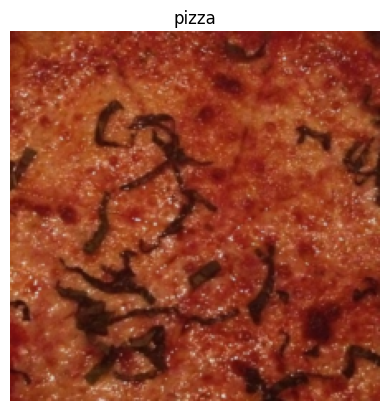

In [26]:
#View single image
plt.imshow(image.permute(1,2,0)) # Adjusted for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [27]:
#Pass the image through the conv layer
image_out_of_conv = conv2d(image.unsqueeze(0)) #adding a single batch dimension making it [batch, height, width, colourchannel]
print(image_out_of_conv.shape) #This gives [batch size, embedding dimensions, feature map height, feature map width]


torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [742, 68, 59, 695, 524]


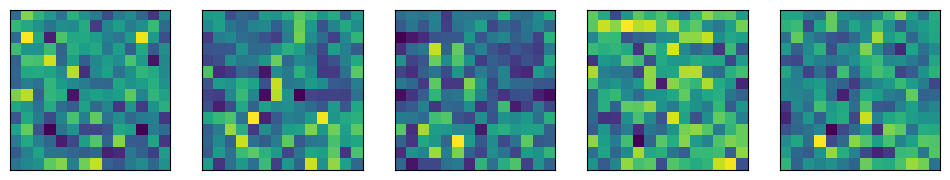

In [28]:
#Plotting five random conv feature maps
import random
random_indexes = random.sample(range(0, 758), k = 5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

#create plot
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12,12))

#Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] #Index on the output tensor of the conv layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = []);


#Flattening the patch embedding with `torch.nn.Flatten()`

From the ViT paper: "As a special case, the patches can have spatial size 1×1, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension."

Let's use`torch.nn.Flatten()` to flatten the spacial dimensions of the feature map, which in our case is the feature_map_heigh and the feature_map_width dimensions.

In [29]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [30]:
#Creating the flatten layer
flatten = nn.Flatten(start_dim = 2,
                     end_dim = 3)

Original input shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


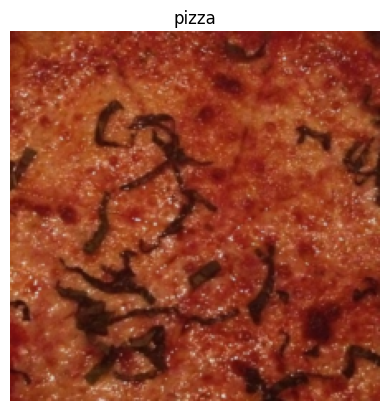

In [31]:
#1. View a single image
plt.imshow(image.permute(1,2,0)) #adjust the dimensions to be compatible with matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original input shape: {image.shape}")

#2. Turn the image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) #adding a dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

#3. Flatten the feature map
image_out_of_conv_flatten = flatten(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flatten.shape}')

In [32]:
#Getting the flattened image patch embeddings into the right shape
image_out_of_conv_flatten_reshaped = image_out_of_conv_flatten.permute(0,2,1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flatten_reshaped.shape}")

Patch embedding sequence shape: torch.Size([1, 196, 768])


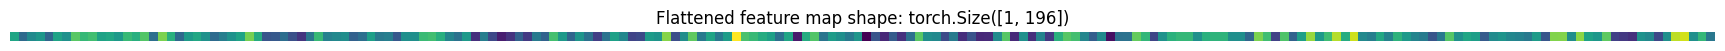

In [33]:
#Lets visualize one of the flattened feature maps
#Getting a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flatten_reshaped[:,:,0]

#Plot the flattened featre map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

This flattened feature map is the output of the patching embedding layer and the input into the rest of the ViT architecture.

#Turning the ViT patch embedding layer into a PyTorch module

In [34]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):

    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [35]:
set_seeds()

#creating an instance of a patch embedding layer

patchify  = PatchEmbedding(in_channels = 3, patch_size = 16, embedding_dim= 768)
#Passing a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [36]:
#Creat random input sizes

random_input_image = (1,3,224,224)
random_input_image_error = (1,3,250,250) #will error cuz the shape is incompatible

# Get a summary of the input and outputs of PatchEmbedding
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

#Creating the class token embedding

In [37]:
#Getting the batch size and the embedding dimensions
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

#Create the class token embedding as a learnable parameter
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

#The first 10 examples of the class_token
print(class_token[:,:,:10])

#Printing the class token shape
print(f'Class token shape: {class_token.shape} --> [batch size, number of tokens, embedding dimensions]')

tensor([[[-2.4663,  0.4867,  0.8128,  0.3298, -1.6121, -0.5759, -0.2281,
           0.2943,  0.1197,  1.5855]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) --> [batch size, number of tokens, embedding dimensions]


In [38]:
#Adding the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim = 1)

print(f'Shape of the patch embeddings with the class token prepended: {patch_embedded_image_with_class_embedding.shape} --> [batch size, number of paches, embedding dimensions]')

Shape of the patch embeddings with the class token prepended: torch.Size([1, 197, 768]) --> [batch size, number of paches, embedding dimensions]


#Creating the position embedding
The position embedding enables the architecture to retain the posiitonal information, which is vital when considering what's in an image.

Position embedding must have the shape (N+1) * D

Where:
1. N = HW/P^2 - the resulting number of patches, which also serves as the effective input sequence length for the Transformer
2. D is the size of the patch embeddings

In [39]:
#Making the learnable 1D embedding
#1. Calculate the number of patches
number_of_patches = int((height*width)/patch_size**2)

#Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
position_embedding = nn.Parameter(torch.randn(1,number_of_patches+1, embedding_dimension),requires_grad = True)#Make sure it's learnable

print(position_embedding[:,:10,:10])

tensor([[[-7.4114e-01,  8.1541e-01, -3.6316e-01,  1.0176e+00,  4.5293e-01,
           9.5421e-01, -1.9018e+00,  9.4062e-02, -1.0380e+00,  8.5705e-01],
         [-6.3292e-01,  6.0168e-01,  7.7370e-01, -6.4148e-01, -1.5129e-02,
          -7.0166e-01, -5.5823e-01,  1.1979e+00,  1.0343e+00, -8.0253e-01],
         [ 4.1812e-01, -8.0315e-01,  6.8380e-01, -6.9289e-01, -3.1867e-01,
          -1.1738e+00, -2.0773e+00,  8.2932e-02, -4.8459e-01,  5.6662e-01],
         [ 9.8222e-01, -2.8216e-01, -8.5354e-01,  9.9346e-02,  4.3550e-02,
           2.0549e-01,  1.7851e+00,  5.2269e-02,  2.8783e-01,  1.2212e+00],
         [ 3.9332e-01, -4.4542e-01, -1.1296e+00,  2.9640e-01,  1.2835e+00,
          -4.3154e-01, -3.4652e-01,  3.9845e+00,  1.7684e+00, -2.0047e-01],
         [-1.0939e+00,  6.1262e-01, -6.9854e-02, -2.3281e-01,  8.0949e-04,
           4.6305e-02, -3.4145e-01, -6.8767e-01, -9.8743e-01,  2.3791e+00],
         [-1.5328e+00, -7.9215e-01, -5.5720e-01,  1.0095e+00, -6.4669e-01,
          -1.2823e+

In [40]:
#Adding the position embedding to the patch and class token
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

#Putting it all together

In [41]:
set_seeds()

#1. Setting the patch size
patch_size = 16

#2. Print shape of original image tensor and get the image dimensions
print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

#3. Get the image tensor and add a batch dimension so it is compatible with our PatchEmbedding layer
x = image.unsqueeze(0)
print(f'Inpt image with batch dimension shape: {x.shape}')

#4. Creating the patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3, patch_size = patch_size, embedding_dim = 768)

#5. Pass the image through the patch embedding layer
patch_embedding  = patch_embedding_layer(x)
print(f'Patching embedding shape: {patch_embedding.shape}')

#6. Create class embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size,1,embedding_dimension), requires_grad = True)
print(f'Class token embedding shape: {class_token.shape}')

#7. Prepend class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim =1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

#8. Create the position embedding
number_of_patches = int((height*width)/patch_size**2)
position_embedding  = nn.Parameter(torch.randn(1,number_of_patches+1,embedding_dimension), requires_grad = True)

#9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')


Image tensor shape: torch.Size([3, 224, 224])
Inpt image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


#Multi-Head Attention (MSA)
We will be using:
1. MSA - `torch.nn.MultiheadAttention()`
2. Norm (LN or LayerNorm) - torch.nn.LayerNorm()`
Residual connection - add the input to the output

####The LayerNorm (LN) layer
Layer Normalization normalizes an input over the last dimension.

PyTorch's `torch.nn.LayerNorm()`'s main parameter is normalized_shape which we can set to be equal to the dimension size we'd like to normalize over(in our case it'll be D or 768 for ViT base)

Layer Normalization helps improve training time and model generalization(ability to adapt to unseen data)

In [42]:
# Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    #Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # hidden size D from table 1 for ViT-Base
                 num_heads:int=12, # heads from table 1 for ViT-Base
                 attn_dropout:float=0): # I don't think the paper uses any dropout in MSABlocks
        super().__init__()

        # Creating the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        #Create the MSA layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does the batch dimension come first?

    #Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [43]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim = 768, num_heads = 12 )

#Passing the patch and position embedding through the multihead self attention block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print(f'Output shape MSA block: {patched_image_through_msa_block.shape}')


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


#Multilayer Perceptron (MLP)
The term MLP is very broad and can refer to almost any combination of multiple layers (hence the 'multi' in multilayer perceptron).

But it generally follows the pattern of
linear layer --> non-linear layer -> linear layer --> non-linear layer

In the case of the Vit architecture described in the paper the MLP structure contains two layers with a GELU(Gaussian Error Linear Units) non-linearity [`torch.nn.GELU()`.

In the appendix B.1 the following paragraph is also found
`Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.`

This means that every linear layer in the MLP block has a dropout layer `torch.nn.Dropout()`. The value for which can be found in table 3 --> dropout = 0.1

Therefore the structure of the MLP block will be as follows:
layer norm --> linear layer --> non-linear layer --> dropout --> linear layer --> dropout

The hyperparameter values for the linear layers are avaliable from Table 1 (MLP size is the number of hidden units between the linear layers and the hidden size D is the output size of the MLP block)


In [44]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int=768,
               mlp_size: int=3072, # MLP size from table 1 for ViT-Base
               dropout: float = 0.1): #Dropout from table 3 for ViT-Base)
      super().__init__()

      self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

      self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [45]:
#Creating an insance of our MLPBLock

mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


#Creating the transformer encoder by combining our custom made layers

In [46]:
#Creating a class that inherits from nn.Module

class TransformerEncoderBlock(nn.Module):

  # Initialize the class with hyperparameter values from the ViT paper (Table 1 and Table3)

  def __init__(self,
               embedding_dim: int = 768,
               num_heads:int = 12,
               mlp_size: int = 3072,
               mlp_dropout: float = 0.1,
               attn_dropout: float = 0):
    super().__init__()


    #Creating the MLA block
    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    #Creating the MLP block
    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout= mlp_dropout)

    #Creating a forward() method
  def forward(self, x):

    #Creating the residual connections for the MSA block (Basically adding the input to the output)
    x = self.msa_block(x) + x

    #Creating the residual connection for the MLP block
    x = self.mlp_block(x) + x

    return x

In [47]:
#Lets create an instance of TransformerEncoderBlock

transformer_encoder_block = TransformerEncoderBlock()

Putting it all together to create the ViT

In [48]:
#create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    # initialize the class with hyperparameters from table 1 and 3
      def __init__(self,
                  img_size:int=224, # Training resolution from Table 3 in ViT paper
                  in_channels:int=3, # Number of channels in input image
                  patch_size:int=16, # Patch size
                  num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                  embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                  mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                  num_heads:int=12, # Heads from Table 1 for ViT-Base
                  attn_dropout:float=0, # Dropout for attention projection
                  mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                  embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                  num_classes:int=1000): # Default for ImageNet but can customize this
          super().__init__()

          #making sure the image size is divisble by the patch size
          assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

          # calculate the number of patches (height * width/patch^2)
          self.num_patches = (img_size * img_size) // patch_size**2

          # Create a learnable class embedding - this goes in front of the sequence of patch embeddings
          self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                              requires_grad=True)

          # Create a learnable position embedding
          self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                                requires_grad=True)

          # Create the embedding dropout value
          self.embedding_dropout = nn.Dropout(p=embedding_dropout)

          # Create a patch embedding layer
          self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                                patch_size=patch_size,
                                                embedding_dim=embedding_dim)

          # Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
          # Note: The "*" means "all"
          self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

          # Create the classifier head
          self.classifier = nn.Sequential(
              nn.LayerNorm(normalized_shape=embedding_dim),
              nn.Linear(in_features=embedding_dim,
                        out_features=num_classes)
          )

      # Create a forward() method
      def forward(self, x):

          # Get batch size
          batch_size = x.shape[0]

          # Create class token embedding and expand it to match the batch size
          class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

          # Create patch embedding
          x = self.patch_embedding(x)

          # Concat class embedding and patch embedding
          x = torch.cat((class_token, x), dim=1)

          # add position embedding to patch embedding
          x = self.position_embedding + x

          # run embedding dropout
          x = self.embedding_dropout(x)

          # pass patch, position and class embedding through transformer encoder layers
          x = self.transformer_encoder(x)

          # put 0 index logit through classifier
          x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

          return x

In [49]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [50]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

The random image tensor has made its way through the ViT architecture andn has output three logit values (one for each class)


#Training
Let's utilize the train() function we defined earlier to train our model. Besides that we also need an optimizer and a loss function.

####1. Optimizer
The paper mentions that they trained all models using adam with a beta1 value of 0.9 and a beta2 value of 0.999, both of which are defaults for the `torch.optim.Adam()` optimizer.

The paper also states that they used a weight decay. A weight decay slowly reduces the values of the weights during optimization to prevent overfitting. We can set this with `torch.optim.Adam(weight_Decay=0.3)`

As per table 3 the learning rate of the optimzier was set to 0.003.

The paper also mentions that the batch sized used was 4096, however my gpu cannot handle that and hence we will be using a batch size of 32.

####2. Loss function
The paper, as far as I could find, did not include any loss function, however considering that this is a multi-class classification model let's use `torch.nn.CrossEntropyLoss()`.  

In [ ]:
#Setting up the optimizer
optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 0.003,
                             betas = (0.9,0.999),
                             weight_decay = 0.3)

#Setting up the loss function
loss_fn = torch.nn.CrossEntropyLoss()

#Set the seed
set_seeds()

#Training
results = train(model = vit,
                train_dataloader = train_dataloader,
                test_dataloader = test_dataloader,
                optimizer = optimizer,
                loss_fn = loss_fn,
                epochs = 10,
                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1311 | train_acc: 0.3398 | test_loss: 4.9150 | test_acc: 0.2604


##How can this model be improved?
The original ViT architecture achieves great results on several image classification benchmarks which are on par with, if not surpasing, many state-of-the-art models. However this model's results aren't really that good.

The main reason for this might be scale, the original model uses far more data while training and also utilizes a longer training schedule as seen in table 3. Additionally there were a few components that we did not include in our model such as: learning rate warmup, learning rate decay, gradient clipping, etc.

Unfortunately these changes are out of the scope of the computational resources avaliable to me.